# Automated Spam Filtering using Naive Bayes

Credit: [@RadimRehurek](https://twitter.com/radimrehurek).

Let's create an app to classify phone SMS messages in English (well, the "SMS kind" of English...) as either "spam" or "ham" (=not spam).

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas
import sklearn
import pickle
import csv

from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC, LinearSVC
from sklearn.metrics import classification_report, f1_score, accuracy_score, confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold, cross_val_score, train_test_split 
from sklearn.tree import DecisionTreeClassifier 
from sklearn.model_selection import learning_curve

/Users/noalubin/patient2rank/venv/lib/python3.7/site-packages/sklearn/feature_extraction/image.py:167: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype=np.int):
/Users/noalubin/patient2rank/venv/lib/python3.7/site-packages/sklearn/linear_model/least_angle.py:35: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more

In [2]:
# Install NLP packages
import nltk
nltk.download('punkt')
!pip install textblob
from textblob import TextBlob

[nltk_data] Downloading package punkt to /Users/noalubin/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


You should consider upgrading via the '/Users/noalubin/patient2rank/venv/bin/python3 -m pip install --upgrade pip' command.


## Step 1: Load data, look around

Let's first download the dataset we'll be using - go to https://archive.ics.uci.edu/ml/datasets/SMS+Spam+Collection and download the zip file. Unzip it under `data` subdirectory. You should see a file called `SMSSpamCollection`, about 0.5MB in size:

```bash
$ ls -l data
total 1352
-rw-r--r--@ 1 kofola  staff  477907 Mar 15  2011 SMSSpamCollection
-rw-r--r--@ 1 kofola  staff    5868 Apr 18  2011 readme
-rw-r-----@ 1 kofola  staff  203415 Dec  1 15:30 smsspamcollection.zip
```

This file contains **a collection of more than 5 thousand SMS phone messages** (see the `readme` file for more info).

We see that this is a [TSV](http://en.wikipedia.org/wiki/Tab-separated_values) ("tab separated values") file, where the first column is a label saying whether the given message is a normal message ("ham") or "spam". The second column is the message itself.

This corpus will be our labeled training set.

[![](http://radimrehurek.com/data_science_python/plot_ML_flow_chart_11.png)](http://www.astroml.org/sklearn_tutorial/general_concepts.html#supervised-learning-model-fit-x-y)

Instead of parsing TSV (or CSV, or Excel...) files by hand, we can use Python's `pandas` library to do the work for us:

In [2]:
messages = pandas.read_csv('/Users/noalubin/Downloads/smsspamcollection/SMSSpamCollection', sep='\t', quoting=csv.QUOTE_NONE,
                           names=["label", "message"])
print(messages)

     label                                            message
0      ham  Go until jurong point, crazy.. Available only ...
1      ham                      Ok lar... Joking wif u oni...
2     spam  Free entry in 2 a wkly comp to win FA Cup fina...
3      ham  U dun say so early hor... U c already then say...
4      ham  Nah I don't think he goes to usf, he lives aro...
...    ...                                                ...
5569  spam  This is the 2nd time we have tried 2 contact u...
5570   ham               Will ü b going to esplanade fr home?
5571   ham  Pity, * was in mood for that. So...any other s...
5572   ham  The guy did some bitching but I acted like i'd...
5573   ham                         Rofl. Its true to its name

[5574 rows x 2 columns]


With `pandas`, we can also view aggregate statistics easily:

In [4]:
messages.groupby('label').describe().T

label                              ham  \
message count                     4827   
        unique                    4518   
        top     Sorry, I'll call later   
        freq                        30   

label                                                        spam  
message count                                                 747  
        unique                                                653  
        top     Please call our customer service representativ...  
        freq                                                    4

How long are the messages?

In [5]:
messages['length'] = messages['message'].map(lambda text: len(text))
messages.head()

,label,message,length
0,ham,"Go until jurong point, crazy.. Available only ...",111
1,ham,Ok lar... Joking wif u oni...,29
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155
3,ham,U dun say so early hor... U c already then say...,49
4,ham,"Nah I don't think he goes to usf, he lives aro...",61


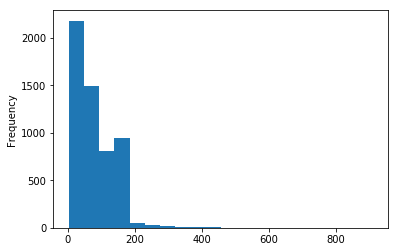

In [6]:
messages.length.plot(bins=20, kind='hist')

In [7]:
messages.length.describe()

count    5574.000000
mean       80.478292
std        59.848302
min         2.000000
25%        36.000000
50%        62.000000
75%       122.000000
max       910.000000
Name: length, dtype: float64

What is that super long message?

In [8]:
print(list(messages.message[messages.length == 910]))

["For me the love should start with attraction.i should feel that I need her every time around me.she should be the first thing which comes in my thoughts.I would start the day and end it with her.she should be there every time I dream.love will be then when my every breath has her name.my life should happen around her.my life will be named to her.I would cry for her.will give all my happiness and take all her sorrows.I will be ready to fight with anyone for her.I will be in love when I will be doing the craziest things for her.love will be when I don't have to proove anyone that my girl is the most beautiful lady on the whole planet.I will always be singing praises for her.love will be when I start up making chicken curry and end up makiing sambar.life will be the most beautiful then.will get every morning and thank god for the day because she is with me.I would like to say a lot..will tell later.."]


Is there any difference in message length between spam and ham?

array([<matplotlib.axes._subplots.AxesSubplot object at 0x1330c37f0>,
      dtype=object)

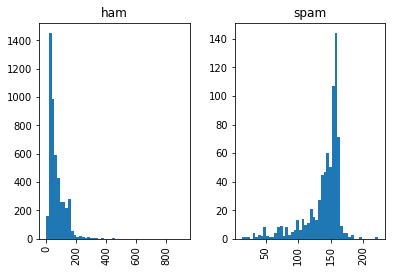

In [9]:
messages.hist(column='length', by='label', bins=50)

Good fun, but how do we make computer understand the plain text messages themselves? Or can it under such malformed gibberish at all?

## Step 2: Data preprocessing

In this section we'll massage the raw messages (sequence of characters) into vectors (sequences of numbers).

The mapping is not 1-to-1; we'll use the [bag-of-words](http://en.wikipedia.org/wiki/Bag-of-words_model) approach, where each unique word in a text will be represented by one number.

As a first step, let's write a function that will split a message into its individual words:

In [10]:
def split_into_tokens(message):
    message = message.encode('utf8').decode()  # convert bytes into proper unicode
    return TextBlob(message).words

Here are some of the original texts again:
    

In [11]:
messages.message.head()

0    Go until jurong point, crazy.. Available only ...
1                        Ok lar... Joking wif u oni...
2    Free entry in 2 a wkly comp to win FA Cup fina...
3    U dun say so early hor... U c already then say...
4    Nah I don't think he goes to usf, he lives aro...
Name: message, dtype: object

...and here are the same messages, tokenized:

In [12]:
messages.message.head().apply(split_into_tokens)

0    [Go, until, jurong, point, crazy, Available, o...
1                       [Ok, lar, Joking, wif, u, oni]
2    [Free, entry, in, 2, a, wkly, comp, to, win, F...
3    [U, dun, say, so, early, hor, U, c, already, t...
4    [Nah, I, do, n't, think, he, goes, to, usf, he...
Name: message, dtype: object

NLP questions:

1. Do capital letters carry information?
2. Does distinguishing inflected form ("goes" vs. "go") carry information?
3. Do interjections, determiners carry information?

In other words, we want to better "normalize" the text.

With textblob, we'd detect [part-of-speech (POS)](http://www.ling.upenn.edu/courses/Fall_2007/ling001/penn_treebank_pos.html) tags with:

and normalize words into their base form ([lemmas](http://en.wikipedia.org/wiki/Lemmatisation)) with:

In [13]:
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/noalubin/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [14]:
def split_into_lemmas(message):
    message = message.encode('utf8').decode().lower()
    words = TextBlob(message).words
    # for each word, take its "base form" = lemma 
    return [word.lemma for word in words]

messages.message.head().apply(split_into_lemmas)

0    [go, until, jurong, point, crazy, available, o...
1                       [ok, lar, joking, wif, u, oni]
2    [free, entry, in, 2, a, wkly, comp, to, win, f...
3    [u, dun, say, so, early, hor, u, c, already, t...
4    [nah, i, do, n't, think, he, go, to, usf, he, ...
Name: message, dtype: object

Better. You can probably think of many more ways to improve the preprocessing: decoding HTML entities (those `&amp;` and `&lt;` we saw above); filtering out stop words (pronouns etc); adding more features, such as an word-in-all-caps indicator and so on.

## Step 3: Data to vectors

Now we'll convert each message, represented as a list of tokens (lemmas) above, into a vector that machine learning models can understand.

Doing that requires essentially three steps, in the bag-of-words model:

1. counting how many times does a word occur in each message (term frequency)
2. weighting the counts, so that frequent tokens get lower weight (inverse document frequency)
3. normalizing the vectors to unit length, to abstract from the original text length (L2 norm)

Each vector has as many dimensions as there are unique words in the SMS corpus:

In [15]:
msg_train, msg_test, label_train, label_test = \
    train_test_split(messages['message'], messages['label'], test_size=0.2)

print( len(msg_train), len(msg_test), len(msg_train) + len(msg_test) )

4459 1115 5574


In [16]:
bow_transformer = CountVectorizer(analyzer=split_into_lemmas).fit(msg_train)
print(len(bow_transformer.vocabulary_))

7902


Here we used `scikit-learn` (`sklearn`), a powerful Python library for teaching machine learning. It contains a multitude of various methods and options.

Let's take one text message and get its bag-of-words counts as a vector, putting to use our new `bow_transformer`:

In [17]:
message4 = messages['message'][3]
print(message4)

U dun say so early hor... U c already then say...


In [18]:
bow4 = bow_transformer.transform([message4])
print(bow4)
print(bow4.shape)

  (0, 1013)	1
  (0, 1654)	1
  (0, 2560)	1
  (0, 2587)	1
  (0, 3561)	1
  (0, 6012)	2
  (0, 6354)	1
  (0, 6875)	1
  (0, 7150)	2
(1, 7902)


So, nine unique words in message nr. 4, two of them appear twice, the rest only once. Sanity check: what are these words the appear twice?

The bag-of-words counts for the entire SMS corpus are a large, sparse matrix:

In [20]:
messages_bow_train = bow_transformer.transform(msg_train)
messages_bow_test = bow_transformer.transform(msg_test)

print( 'sparse matrix shape:', messages_bow_train.shape)
print( 'number of non-zeros:', messages_bow_train.nnz)
print( 'sparsity: %.2f%%' % (100.0 * messages_bow_train.nnz / (messages_bow_train.shape[0] * messages_bow_train.shape[1])))

sparse matrix shape: (4459, 7902)
number of non-zeros: 64329
sparsity: 0.18%


There are a multitude of ways in which data can be proprocessed and vectorized. These two steps, also called "feature engineering", are typically the most time consuming and "unsexy" parts of building a predictive pipeline, but they are very important and require some experience. The trick is to evaluate constantly: analyze model for the errors it makes, improve data cleaning & preprocessing, brainstorm for new features, evaluate...

## Step 4: Training a model, detecting spam

With messages represented as vectors, we can finally train our spam/ham classifier. This part is pretty straightforward, and there are many libraries that realize the training algorithms.

We'll be using scikit-learn here, choosing the [Naive Bayes](http://en.wikipedia.org/wiki/Naive_Bayes_classifier) classifier to start with:

In [21]:
%time spam_detector = MultinomialNB().fit(messages_bow_train, label_train)

CPU times: user 11.1 ms, sys: 1.66 ms, total: 12.8 ms
Wall time: 11.5 ms


Hooray! You can try it with your own texts, too.

A natural question is to ask, how many messages do we classify correctly overall?

In [22]:
all_predictions = spam_detector.predict(messages_bow_test)
print( all_predictions)

['ham' 'ham' 'spam' ... 'spam' 'ham' 'ham']


In [23]:
print( 'accuracy', accuracy_score(label_test, all_predictions))
print( 'confusion matrix\n', confusion_matrix(label_test, all_predictions))
print( '(row=expected, col=predicted)')

accuracy 0.9820627802690582
confusion matrix
 [[954   3]
 [ 17 141]]
(row=expected, col=predicted)


Text(0.5, 0, 'predicted label')

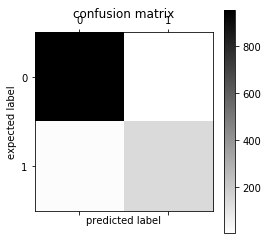

In [24]:
plt.matshow(confusion_matrix(label_test, all_predictions), cmap=plt.cm.binary, interpolation='nearest')
plt.title('confusion matrix')
plt.colorbar()
plt.ylabel('expected label')
plt.xlabel('predicted label')

From this confusion matrix, we can compute precision and recall, or their combination (harmonic mean) F1:

In [32]:
print(classification_report(label_test, all_predictions))

              precision    recall  f1-score   support

         ham       0.98      1.00      0.99       957
        spam       0.98      0.89      0.93       158

   micro avg       0.98      0.98      0.98      1115
   macro avg       0.98      0.94      0.96      1115
weighted avg       0.98      0.98      0.98      1115



There are quite a few possible metrics for evaluating model performance. Which one is the most suitable depends on the task. For example, the cost of mispredicting "spam" as "ham" is probably much lower than mispredicting "ham" as "spam".